# **The Problem: Automatic Apparent Age Estimation**

# Pre-requisites:
Installing tensorflow-gpu (GPU) and OpenCv.
Check GPU usage instructions [here](https://research.google.com/colaboratory/faq.html#gpu-availability)

In [ ]:
!pip install tensorflow-gpu==2.4.0
!pip install opencv-python
!pip install h5py

# Downloading and decompressing the Appa-Real Age Dataset [(source)](http://chalearnlap.cvc.uab.es/challenge/13/track/13/description/)
- As default, RGB images (cropped faces) are in the range of [0, 255], and labels are in the range of ~0.9 to ~90 (years old).
- The data is divided in train, validation and test set. 
- Matadata is also provided
  - gender: male / female 
  - ethnicity: asian / afroamerican / caucasian
  - facial expression: neutral / slightlyhappy / happy / oth

In [2]:
from zipfile import ZipFile

In [ ]:
# downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip

with ZipFile('app_data.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data.zip

# Loading the train/validation data, and re-scaling the labels to [0..1]
Perform the split and the metadata extraction:
- X_[train,valid,test] = Face images
- Y_[train,valid,test] = Ground truth 
- M_[train,valid,test] = Metadata (gender, ethnicicy, facial expression)

In [4]:
import numpy as np

# loading the train data
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100
# Y_test = Y_test/100 # -> we don't normalize the test labels as we will evaluate 
                      # them using the raw data, i.e., the apparent age values

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Test data size and shape', X_test.shape)
print('Test labels size and shape', Y_test.shape)
print('Test metadata size and shape', M_test.shape)

Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)
Test labels size and shape (1978,)
Test metadata size and shape (1978, 3)


# Visualizations

Can be checked in the original baseline notebook.

# Preprocessing the data (face images)

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# train
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

# validation
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = preprocess_input(x)  

# test
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = preprocess_input(x)

# Downloading the ResNet50 model pre-trained on Faces

In [ ]:
# downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

# decompressing the data
with ZipFile('model.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm model.zip

# Loading the pre-trained model

In [7]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# loading the pretrained model
model = tf.keras.models.load_model('./model/weights.h5')

# print the model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

# Adapting the model to our needs
- In summary, we will ignore the last layer 'classifier_low_dim' and will include a few other layers on top of our backbone. Here, we also define the activation function we are going to use as output of the last FC layer (Sigmoid, in the case).

In [8]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# adding a dropout layer to minimize overfiting problems
dp_layer_1 = Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
fc_128 = Dense(128, activation='relu', name='f_128')(dp_layer_1)
fc_32 = Dense(32, activation='relu', name='f_32')(fc_128)

# adding a dropout layer to minimize overfiting problems
dp_layer_2 = Dropout(0.5)(fc_32)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = Dense(1, activation='sigmoid', name='predict')(dp_layer_2)

# building and pringing the final model
model = Model(inputs=model.get_layer('base_input').output,outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

# Freezing the first layers to allow the fine-tuning of the last FC layers (only)
- Next, we set some layer to be trainable or not, and print if layers are set to trainable = True or False.


In [9]:
counter = 0
for layer in model.layers:
  if counter <= 174: 
    layer.trainable = False
  else:
    layer.trainable = True
  print(counter, layer.name, layer.trainable)
  counter +=1

0 base_input False
1 conv1/7x7_s2 False
2 conv1/7x7_s2/bn False
3 activation_1 False
4 max_pooling2d_1 False
5 conv2_1_1x1_reduce False
6 conv2_1_1x1_reduce/bn False
7 activation_2 False
8 conv2_1_3x3 False
9 conv2_1_3x3/bn False
10 activation_3 False
11 conv2_1_1x1_increase False
12 conv2_1_1x1_proj False
13 conv2_1_1x1_increase/bn False
14 conv2_1_1x1_proj/bn False
15 add_1 False
16 activation_4 False
17 conv2_2_1x1_reduce False
18 conv2_2_1x1_reduce/bn False
19 activation_5 False
20 conv2_2_3x3 False
21 conv2_2_3x3/bn False
22 activation_6 False
23 conv2_2_1x1_increase False
24 conv2_2_1x1_increase/bn False
25 add_2 False
26 activation_7 False
27 conv2_3_1x1_reduce False
28 conv2_3_1x1_reduce/bn False
29 activation_8 False
30 conv2_3_3x3 False
31 conv2_3_3x3/bn False
32 activation_9 False
33 conv2_3_1x1_increase False
34 conv2_3_1x1_increase/bn False
35 add_3 False
36 activation_10 False
37 conv3_1_1x1_reduce False
38 conv3_1_1x1_reduce/bn False
39 activation_11 False
40 conv3_1_3x3

# Analyze bias functions

---
# Age Bias ($B_a$) 

- Evaluates (on the TEST set) how accurate the model is with respect to different age ranges.
  - group 1: age < 20
  - group 2: 20 <= age < 40
  - group 3: 40 <= age < 60
  - group 4: 60 <= age

In [10]:
def age_bias(predictions, gt):
  error_g1 = []
  error_g2 = []
  error_g3 = []
  error_g4 = []
  for i in range(0,len(gt)):
    if(gt[i]<20):
      error_g1.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=20 and gt[i]<40):
      error_g2.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=40 and gt[i]<60):
      error_g3.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=60):
      error_g4.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Age analysis:')
  print('Size group 1 = %d, MAE = %f' %(len(error_g1), np.mean(error_g1)))
  print('Size group 2 = %d, MAE = %f' %(len(error_g2), np.mean(error_g2)))
  print('Size group 3 = %d, MAE = %f' %(len(error_g3), np.mean(error_g3)))
  print('Size group 4 = %d, MAE = %f' %(len(error_g4), np.mean(error_g4)))

  age_bias = (abs(np.mean(error_g1)-np.mean(error_g2)) +
            abs(np.mean(error_g1)-np.mean(error_g3)) +
            abs(np.mean(error_g1)-np.mean(error_g4)) +
            abs(np.mean(error_g2)-np.mean(error_g3)) +
            abs(np.mean(error_g2)-np.mean(error_g4)) +
            abs(np.mean(error_g3)-np.mean(error_g4)))/6

  print('---------')
  print('Age bias (Ba) = ', age_bias)

# Gender Bias ($B_g$) 
- Evaluates (on the test set) how accurate the model is with respect to different gender.
  - group 1: male
  - group 2: female

In [11]:
def gender_bias(predictions, gt, metadata):
  error_m = []
  error_f = []
  for i in range(0,len(gt)):
    if(metadata[i][0] == 'female'):
      error_f.append(abs(predictions[i]-gt[i]))
    else:
      error_m.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Gender analysis:')
  print('Size group female = %d, MAE = %f' %(len(error_f), np.mean(error_f)))
  print('Size group male = %d, MAE = %f' %(len(error_m), np.mean(error_m)))

  gender_bias = abs(np.mean(error_f)-np.mean(error_m))

  print('---------')
  print('Gender bias (Bg) = ', gender_bias)

# Ethnicity Bias ($B_e$)
- Evaluates (on the test set) how accurate the model is with respect to different ethnicity categories.
  - group 1: asian
  - group 2: afroamerican
  - group 3: caucasian


In [12]:
def ethnicity_bias(predictions, gt, metadata):
  error_as = []
  error_af = []
  error_ca = []
  for i in range(0,len(gt)):
    if(metadata[i][1] == 'asian'):
      error_as.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'afroamerican'):
      error_af.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'caucasian'):
      error_ca.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Ethnicity Analysis:')
  print('Size group asian = %d, MAE = %f' %(len(error_as), np.mean(error_as)))
  print('Size group afroamerican = %d, MAE = %f' %(len(error_af), np.mean(error_af)))
  print('Size group caucasian = %d, MAE = %f' %(len(error_ca), np.mean(error_ca)))
  
  ethnicity_bias = (abs(np.mean(error_as)-np.mean(error_af)) +
                   abs(np.mean(error_as)-np.mean(error_ca)) +
                   abs(np.mean(error_af)-np.mean(error_ca)))/3

  print('---------')
  print('Ethnicity bias (Be) = ', ethnicity_bias)

# Face expression bias ($B_f$)
- Evaluates (on the test set) how accurate the model is with respect to different face expression categories.
  - group 1: neutral
  - group 2: slightlyhappy
  - group 3: happy
  - group 4: other

In [13]:
def face_expression_bias(predictions, gt, metadata):
  error_h = []
  error_s = []
  error_n = []
  error_o = []
  for i in range(0,len(gt)):
    if(metadata[i][2]=='happy'):
      error_h.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='slightlyhappy'):
      error_s.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='neutral'):
      error_n.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='other'):
      error_o.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Face experession Analysis:')
  print('Size group happy = %d, MAE = %f' %(len(error_h), np.mean(error_h)))
  print('Size group slightlyhappy = %d, MAE = %f' %(len(error_s), np.mean(error_s)))
  print('Size group neutral = %d, MAE = %f' %(len(error_n), np.mean(error_n)))
  print('Size group other = %d, MAE = %f' %(len(error_o), np.mean(error_o)))

  face_bias = (abs(np.mean(error_h)-np.mean(error_s)) +
              abs(np.mean(error_h)-np.mean(error_n)) +
              abs(np.mean(error_h)-np.mean(error_o)) +
              abs(np.mean(error_s)-np.mean(error_n)) +
              abs(np.mean(error_s)-np.mean(error_o)) +
              abs(np.mean(error_n)-np.mean(error_o)))/6

  print('---------')
  print('Face Expression bias (Bf) = ', face_bias)

# Data augmentation

First, let's check the number of samples per each age group of the training set.

In [14]:
num_samples = len(Y_train)

In [15]:
group1 = Y_train[Y_train*100 < 20]
group2 = Y_train[(Y_train*100 >= 20) & (Y_train*100 < 40)]
group3 = Y_train[(Y_train*100 >= 40) & (Y_train*100 < 60)]
group4 = Y_train[Y_train*100 >= 60]

print('Num samples group1', len(group1), '(' + str(len(group1) / num_samples) + '%)')
print('Num samples group2', len(group2), '(' + str(len(group2) / num_samples) + '%)')
print('Num samples group3', len(group3), '(' + str(len(group3) / num_samples) + '%)')
print('Num samples group4', len(group4), '(' + str(len(group4) / num_samples) + '%)')

Num samples group1 796 (0.1958179581795818%)
Num samples group2 2389 (0.58769987699877%)
Num samples group3 732 (0.18007380073800738%)
Num samples group4 148 (0.036408364083640836%)


As expected the number of samples of the last group (>=60) is the one with the least number of samples. The following cells performed, at first, 4 augmentations for that group increasing the number of samples to 592. This helps to reduce the bias but it's not enough, the group is not reaching the number of samples of the other groups with less ones (700-800).

So, from our point of view, each group should have a similar number of samples in order to reduce that bias. Then, we should generate ~2.3k samples for each group (the second group already has them). To do that, we can use one or more data augmentation techniques to reach that goal, let's compute how much techniques we should apply to the dataset to reach that numbers.

In [16]:
print('For group 1:', len(group2) // len(group1) - 1, 'augmentations. Final number of samples:', len(group1) * (len(group2) // len(group1)))
print('For group 3:', len(group2) // len(group3) - 1, 'augmentations. Final number of samples:', len(group3) * (len(group2) // len(group3)))
print('For group 4:', len(group2) // len(group4) - 1, 'augmentations. Final number of samples:', len(group4) * (len(group2) // len(group4)))

For group 1: 2 augmentations. Final number of samples: 2388
For group 3: 2 augmentations. Final number of samples: 2196
For group 4: 15 augmentations. Final number of samples: 2368


In order to avoid repeating or transforming way too many times the same sample, we will reduce proportionally the number of transformations for each group. They will not have the same number of samples as the largest group, but they will be close enough: the bias will be mitigated and the largest group will not be very damaged in this sense.
- 1 augmentation for group 1
- 1 augmentation for group 3
- 8 augmentations for group 4

In [17]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
import random

# aux variables
X_train_augmented = []
Y_train_augmented = []
M_train_augmented = []

# loading the train data and labels
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100
print('Train set before augmentation = ', np.array(X_train).shape)

# augmenting the data
for i in range(0,len(X_train)):
  #### MY CODE
  if Y_train[i]*100 < 20:
    # First group, do one augmentation, e.g. flip
    X_train_augmented.append(cv2.flip(X_train[i], 1))
    Y_train_augmented.append(Y_train[i]) 
    M_train_augmented.append(M_train[i]) 
  if Y_train[i]*100 >= 40 and Y_train[i]*100 < 60:
    # Third group, do one augmentation, e.g. flip
    X_train_augmented.append(cv2.flip(X_train[i], 1))
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 

  ####
  
  # check if image is in the group 'age >= 60'
  if Y_train[i]*100>=60: # here labels are multiplied by 100 as they were normalized to be between [0,1]
    # flip
    x_flipped = cv2.flip(X_train[i], 1)
    X_train_augmented.append(x_flipped)
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 

    # changing brightness
    x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 

    # blur
    X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 
   
    # translation
    rows, cols ,c= X_train[i].shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    X_train_augmented.append(cv2.warpAffine(X_train[i], M, (cols, rows)))
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 

    #### MY CODE
    # Fourth group, add 3 augmentations
    # change brightness to flipped image
    x_aux = cv2.cvtColor(x_flipped,cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 

    # gaussian blur to flipped image
    X_train_augmented.append(cv2.GaussianBlur(x_flipped,(5,5),1.0))
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 

    # translation to flipped image
    rows, cols ,c= x_flipped.shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    X_train_augmented.append(cv2.warpAffine(x_flipped, M, (cols, rows)))
    Y_train_augmented.append(Y_train[i])
    M_train_augmented.append(M_train[i]) 

    ####

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train = np.concatenate((M_train, M_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)


# post-processing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

Train set before augmentation =  (4065, 224, 224, 3)
Train set after augmentation =  (6629, 224, 224, 3)


Now, something similar has to be done for the rest of biases, without breaking the balancing we have already done for age groups.

In [20]:
## Convert the Y_train age labels for the age group the samples are included in. (E.g.: if item at index i in Y_train has a value of 25, its value will be 2 in binning)
import bisect

score_ranges =  [0, 0.2, 0.4, 0.6, 2]
binning = []

for a in Y_train:
    binning.append(bisect.bisect_left(score_ranges, a))

binning = np.array(binning)


To do that, we should first count how many items of each kind are available. A kind of sample is any possible combination of race and emotion. We are ignoring the gender variable because we found ourselves with a pretty well balanced scenario in this feature.

Also, we will get the age distribution within each sample class.

With this information, we will retrieve the number of transformations that all samples of a sample class should go through in order for all classes to have approximately the same amount of samples.

In [21]:
import collections

for race in ['caucasian', 'asian', 'afroamerican']:
  for emotion in ['neutral', 'happy', 'slightlyhappy', 'other']:
    filtered = np.all(M_train[:, 1:] == [race, emotion], axis=1)
    num_samples = len(filtered[filtered])
    ages = dict(sorted(dict(collections.Counter(binning[filtered])).items()))
    print('[' + race + ', ' + emotion + ']: ' + str(num_samples) + ' samples.')
    print('      Age distribution: ', ages)
    if emotion != 'other':
      print('      Needs ' + str(2443//num_samples - 1) + ' augmentations. Final samples: ' + str(2443//num_samples * num_samples))

[caucasian, neutral]: 2215 samples.
      Age distribution:  {1: 577, 2: 618, 3: 468, 4: 552}
      Needs 0 augmentations. Final samples: 2215
[caucasian, happy]: 927 samples.
      Age distribution:  {1: 168, 2: 393, 3: 238, 4: 128}
      Needs 1 augmentations. Final samples: 1854
[caucasian, slightlyhappy]: 2443 samples.
      Age distribution:  {1: 528, 2: 937, 3: 618, 4: 360}
      Needs 0 augmentations. Final samples: 2443
[caucasian, other]: 267 samples.
      Age distribution:  {1: 78, 2: 79, 3: 38, 4: 72}
[asian, neutral]: 238 samples.
      Age distribution:  {1: 86, 2: 86, 3: 42, 4: 24}
      Needs 9 augmentations. Final samples: 2380
[asian, happy]: 80 samples.
      Age distribution:  {1: 22, 2: 54, 3: 4}
      Needs 29 augmentations. Final samples: 2400
[asian, slightlyhappy]: 273 samples.
      Age distribution:  {1: 78, 2: 141, 3: 22, 4: 32}
      Needs 7 augmentations. Final samples: 2184
[asian, other]: 22 samples.
      Age distribution:  {1: 10, 2: 2, 3: 2, 4: 8}
[af

As we did for the age groups, we will reduce the number of transformations respecting proportions as well as possible. We are going to ignore the 'other' emotion, as it is residual. The number of transformations we will apply is returned by the following method:

In [22]:
def get_number_of_needed_transformations(sample_metadata):
  if sample_metadata[1] == 'caucasian':
    return 0
  elif sample_metadata[1] == 'asian':
    if sample_metadata[2] == 'happy':
      return 5
    else:
      return 2
  else:
    if sample_metadata[2] == 'neutral':
      return 8
    else:
      return 11

Now, in order to mantain the balance in the age groups: we will distribute the number of transformations within a class taking into account how many of those samples fall into each age group. In that sense, group 2 samples will generally suffer less transformations, while need more samples.

In [23]:
# Util method
def add_all(augX, augY, augZ, X, Y, Z, rep, bin):
    for j in range(rep[bin]):
      augX.append(X)
      augY.append(Y)
      augZ.append(Z)

    return augX, augY, augZ

In [24]:
X_train_augmented = []
Y_train_augmented = []
M_train_augmented = []

for i in range(len(X_train)):
  X_actual = X_train[i]
  bin_actual = binning[i] - 1
  Y_actual = Y_train[i]
  M_actual = M_train[i]

  if M_actual[1] == 'caucasian' and M_actual[2] == 'happy':
    repetitions = [2, 0, 1, 2]
  elif M_actual[1] == 'asian' and M_actual[2] == 'neutral':
    repetitions = [1, 1, 3, 6]
  elif M_actual[1] == 'asian' and M_actual[2] == 'happy':
    repetitions = [10, 4, 18, 0]
  elif M_actual[1] == 'asian' and M_actual[2] == 'slightlyhappy':
    repetitions = [2, 1, 5, 5]
  elif M_actual[1] == 'afroamerican' and M_actual[2] == 'neutral':
    repetitions = [10, 8, 6, 0]
  elif M_actual[1] == 'afroamerican' and M_actual[2] == 'happy':
    repetitions = [8, 8, 20, 0]
  elif M_actual[1] == 'afroamerican' and M_actual[2] == 'slightlyhappy':
    repetitions = [10, 5, 20, 0]
  else:
    continue
    
  X_train_augmented, Y_train_augmented, M_train_augmented = add_all(X_train_augmented, Y_train_augmented, M_train_augmented, X_actual, Y_actual, M_actual, repetitions, bin_actual)

X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train = np.concatenate((M_train, M_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)

Train set after augmentation =  (10100, 224, 224, 3)


Now the dataset should be augmented enough.

# Training the Model / or downloading a model already trained
- As default, the code below will load a pre-trained model, obtained using the same code if LOAD_BEST_MODEL_ST1 is set to False.
- Later, you can set LOAD_BEST_MODEL_ST1 to False to perfom the training.
  - The code below uses Early stopping (es) with patience = 5 (that is, the training will stop if no improvement on valid_loss is observed on the last 5 epochs).
  - It uses the Mean Squared Error (MSE) as loss function ('loss=tf.keras.losses.MeanSquaredError()'). The code also evaluates the Mean Absolute Error (MAE) during training ('metrics=['mae']'). Learning rate is set to 'learning_rate=1e-5', batch size = 32, and the model will be trained for 50 epochs (if Colab allows it based to the time budget)
  - The model callback (mc) is set to save the best model based on valid_loss (that is, if validation loss decreases from one epoch to another, a new model is saved on the path you specify).
  - Other hyperparameters you can play with are: defining another optimizer, loss function, learning rate, batch size, num of epochs.
  

- Note: in case you want to save your model, stop training, and resume training, check the end of this file **"II) illustrating how to train + save + stop training + RESUME TRAINING"** where we provide a more detailed example about this procedure. Recommendation: first train your model for a few epochs to avoid the need of resume training. This way, you will get used with the code and the general pipeline. Later, you can play with that.

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle

# load a model and train history (defined and trained
# as below, trained for 38 epochs)
#--------------------------
LOAD_BEST_MODEL_ST1 = False # (training only the last FC layers)
#--------------------------


if(LOAD_BEST_MODEL_ST1==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
  # decompressing the data
  with ZipFile('best_model_st1.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st1.zip
  
else:
  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model based on val_loss
  mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # training the model
  history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=64, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history (for future visualization)
  with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
158/158 [==============================] - 35s 177ms/step - loss: 0.3600 - mae: 0.3649 - val_loss: 0.2924 - val_mae: 0.3030
Epoch 2/50
158/158 [==============================] - 26s 163ms/step - loss: 0.3375 - mae: 0.3416 - val_loss: 0.2298 - val_mae: 0.1881
Epoch 3/50
158/158 [==============================] - 26s 165ms/step - loss: 0.2663 - mae: 0.2400 - val_loss: 0.2090 - val_mae: 0.1459
Epoch 4/50
158/158 [==============================] - 26s 167ms/step - loss: 0.2259 - mae: 0.1803 - val_loss: 0.2006 - val_mae: 0.1205
Epoch 5/50
158/158 [==============================] - 27s 170ms/step - loss: 0.2196 - mae: 0.1670 - val_loss: 0.1989 - val_mae: 0.1150
Epoch 6/50
158/158 [==============================] - 27s 172ms/step - loss: 0.2156 - mae: 0.1589 - val_loss: 0.1978 - val_mae: 0.1115
Epoch 7/50
158/158 [==============================] - 27s 174ms/step - loss: 0.2140 - mae: 0.1543 - val_loss: 0.1973 - val_mae: 0.1096
Epoch 8/50
158/158 [==============================] - 2

# Visualizing train history

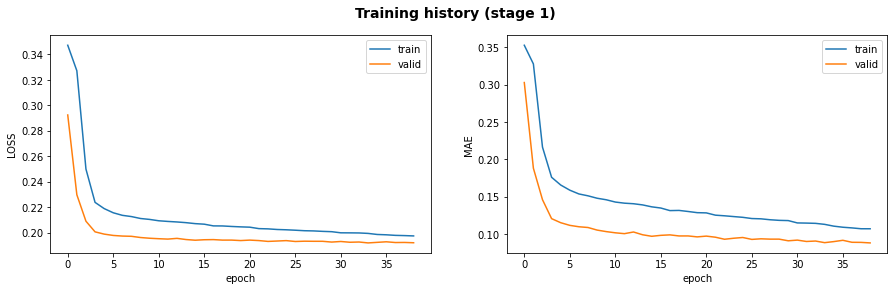

In [26]:
import pickle
from matplotlib import pyplot as plt

# here, it loads the history of the model we have already trained, or loads the 
# history of the model you defined and trained
if(LOAD_BEST_MODEL_ST1==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')  


# Evaluate on test set

In [27]:
from tensorflow.keras.models import load_model

#--------------------------
ENABLE_EVALUATION_ST1 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST1==True):
  saved_model = load_model('best_model.h5')
else:
  saved_model = load_model('/content/gdrive/MyDrive/temp/best_model.h5')

if(ENABLE_EVALUATION_ST1==True):
  # predict on the test data
  predictions_st1 = saved_model.predict(X_test, batch_size=32, verbose=1)

62/62 [==============================] - 7s 87ms/step


In [28]:
if(ENABLE_EVALUATION_ST1==True):
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_st1_f = predictions_st1*100

  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_st1_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 9.73926248


---
# Performing a 2nd Stage of training, where ALL Layers are set to "trainable"
- Up to here, we have just trained the last FC layers of our model. Now, we will load the model we have trained (referred to it as 1st stage), set all layers to TRAINABLE, and train the whole model. Training will take more time, but we expect to get better results.

In [29]:
# setting all layers of the model to trainable
saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
  print(counter, layer.name, layer.trainable)
  counter +=1

0 base_input True
1 conv1/7x7_s2 True
2 conv1/7x7_s2/bn True
3 activation_1 True
4 max_pooling2d_1 True
5 conv2_1_1x1_reduce True
6 conv2_1_1x1_reduce/bn True
7 activation_2 True
8 conv2_1_3x3 True
9 conv2_1_3x3/bn True
10 activation_3 True
11 conv2_1_1x1_increase True
12 conv2_1_1x1_proj True
13 conv2_1_1x1_increase/bn True
14 conv2_1_1x1_proj/bn True
15 add_1 True
16 activation_4 True
17 conv2_2_1x1_reduce True
18 conv2_2_1x1_reduce/bn True
19 activation_5 True
20 conv2_2_3x3 True
21 conv2_2_3x3/bn True
22 activation_6 True
23 conv2_2_1x1_increase True
24 conv2_2_1x1_increase/bn True
25 add_2 True
26 activation_7 True
27 conv2_3_1x1_reduce True
28 conv2_3_1x1_reduce/bn True
29 activation_8 True
30 conv2_3_3x3 True
31 conv2_3_3x3/bn True
32 activation_9 True
33 conv2_3_1x1_increase True
34 conv2_3_1x1_increase/bn True
35 add_3 True
36 activation_10 True
37 conv3_1_1x1_reduce True
38 conv3_1_1x1_reduce/bn True
39 activation_11 True
40 conv3_1_3x3 True
41 conv3_1_3x3/bn True
42 activati

# Train the whole model

In [30]:
# Loding a pretrained model or train
#--------------------------
LOAD_BEST_MODEL_ST2 = False
#--------------------------

if(LOAD_BEST_MODEL_ST2==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2.zip
  # decompressing the data
  with ZipFile('best_model_st2.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2.zip

else:
  
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=12, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)



Epoch 1/12
632/632 [==============================] - 117s 173ms/step - loss: 0.2035 - mae: 0.1270 - val_loss: 0.1878 - val_mae: 0.0830
Epoch 2/12
632/632 [==============================] - 108s 171ms/step - loss: 0.1925 - mae: 0.1008 - val_loss: 0.1836 - val_mae: 0.0745
Epoch 3/12
632/632 [==============================] - 108s 171ms/step - loss: 0.1880 - mae: 0.0929 - val_loss: 0.1806 - val_mae: 0.0730
Epoch 4/12
632/632 [==============================] - 108s 171ms/step - loss: 0.1843 - mae: 0.0897 - val_loss: 0.1771 - val_mae: 0.0688
Epoch 5/12
632/632 [==============================] - 108s 171ms/step - loss: 0.1809 - mae: 0.0854 - val_loss: 0.1742 - val_mae: 0.0682
Epoch 6/12
632/632 [==============================] - 108s 171ms/step - loss: 0.1768 - mae: 0.0813 - val_loss: 0.1704 - val_mae: 0.0659
Epoch 7/12
632/632 [==============================] - 108s 171ms/step - loss: 0.1737 - mae: 0.0816 - val_loss: 0.1677 - val_mae: 0.0662
Epoch 8/12
632/632 [============================

# Visualizing the Training history of both stages (1st stage and 2nd stage)

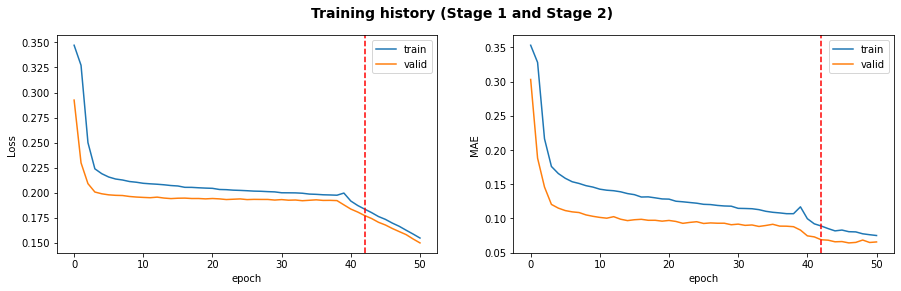

In [31]:
if(LOAD_BEST_MODEL_ST1==True and LOAD_BEST_MODEL_ST2==True):
    train_hist = pickle.load(open("train_history.pkl","rb"))
    train_hist_2nd = pickle.load(open("train_history_2nd_stage.pkl","rb"))
else:
    train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))
    train_hist_2nd = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl","rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
ax1.axvline(42, 0, 1, ls='--', color='r')
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
ax2.axvline(42, 0, 1, ls='--', color='r')
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

# Evaluate on test set

In [32]:
#--------------------------
ENABLE_EVALUATION_ST2 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST2 == True):
  saved_model_2nd = load_model('best_model_2nd_stage.h5')
else:
  saved_model_2nd = load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5')


if(ENABLE_EVALUATION_ST2==True):
  # predict on the test data
  predictions_2nd = saved_model_2nd.predict(X_test, batch_size=32, verbose=1)

  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_2nd_f = predictions_2nd*100

62/62 [==============================] - 6s 78ms/step


In [33]:
if(ENABLE_EVALUATION_ST2==True):
  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_2nd_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 7.46678216


# Check the biases

In [36]:
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2)
  age_bias(predictions_2nd_f,Y_test)

  # computing the gender bias (model_stage_2)
  gender_bias(predictions_2nd_f,Y_test,M_test)

  # computing the ethnicity bias (model_stage_2)
  ethnicity_bias(predictions_2nd_f,Y_test,M_test)

  # computing the face bias (model_stage_2)
  face_expression_bias(predictions_2nd_f,Y_test,M_test)

Age analysis:
Size group 1 = 369, MAE = 7.372414
Size group 2 = 1044, MAE = 6.207960
Size group 3 = 390, MAE = 6.687294
Size group 4 = 175, MAE = 16.912683
---------
Age bias (Ba) =  5.4665482838948565
Gender analysis:
Size group female = 1020, MAE = 7.623360
Size group male = 958, MAE = 7.300071
---------
Gender bias (Bg) =  0.3232894
Ethnicity Analysis:
Size group asian = 129, MAE = 7.273325
Size group afroamerican = 56, MAE = 7.300735
Size group caucasian = 1793, MAE = 7.485887
---------
Ethnicity bias (Be) =  0.1417077382405599
Face experession Analysis:
Size group happy = 589, MAE = 7.656462
Size group slightlyhappy = 505, MAE = 7.573052
Size group neutral = 756, MAE = 7.264775
Size group other = 128, MAE = 7.367793
---------
Face Expression bias (Bf) =  0.23005358378092447


# Saving the predicted values (on Test set) to be uploaded on Codalab Competition

In [37]:
import csv

if(ENABLE_EVALUATION_ST2==True):
  # saving the predictions as a csv file
  with open('predictions.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(predictions_2nd_f)
  csvFile.close()

  # compressing the csv file (to be submitted to codalab as prediction)
  ! zip predictions.zip predictions.csv

updating: predictions.csv (deflated 55%)
